In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import seaborn as sns

from data import load_mnist_dataloader
from networks import *
from train import *

from warnings import filterwarnings
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

filterwarnings("ignore")

ModuleNotFoundError: No module named 'data'

In [25]:
input_size = 28 * 28
hidden_size = 128
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

model_path = 'fully_connected_one_layer_mnist.pth'
model = FullyConnectedOneLayer(input_size, hidden_size, num_classes)
if model_path not in os.listdir('models'):
    train_loader, test_loader = load_mnist_dataloader(batch_size)
    model, criterion, optimizer = load_fully_connected_one_layer(input_size, hidden_size, num_classes, learning_rate)
    train(model, criterion, optimizer, train_loader, num_epochs)
    save_model(model, f'models/{model_path}')
else:
    load_model(model, f'models/{model_path}')

Model loaded from models/fully_connected_one_layer_mnist.pth


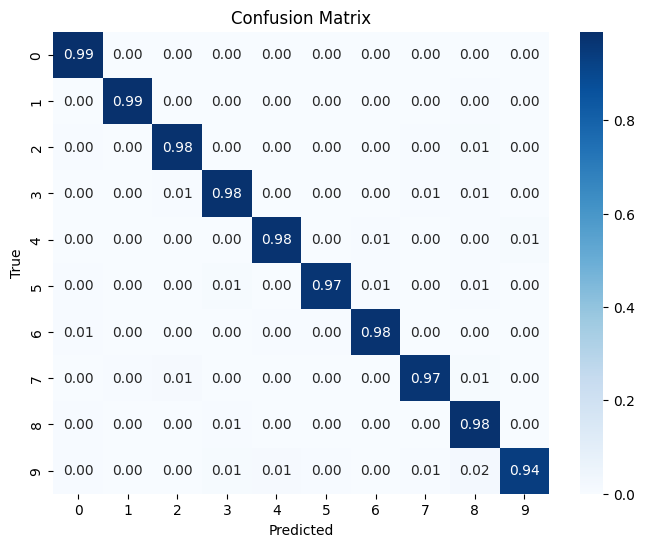

In [26]:
train_loader, test_loader = load_mnist_dataloader(batch_size)

def create_confusion_matrix(dataloader, model, n_classes=10):

    confusion_matrix = np.zeros((n_classes, n_classes))

    for i in range(len(dataloader.dataset)):
        x, label = dataloader.dataset[i]
        out = model(x).detach().numpy()
        pred = np.argmax(out)
        confusion_matrix[label, pred] += 1

    for i in range(n_classes):
        confusion_matrix[i] /= np.sum(confusion_matrix[i])

    return confusion_matrix

def plot_confusion_matrix(confusion_matrix, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.2f')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


confusion_matrix = create_confusion_matrix(test_loader, model)
plot_confusion_matrix(confusion_matrix)

[0.1180196  0.10417739 0.11191223 ... 0.1458078  0.11841004 0.12668973]


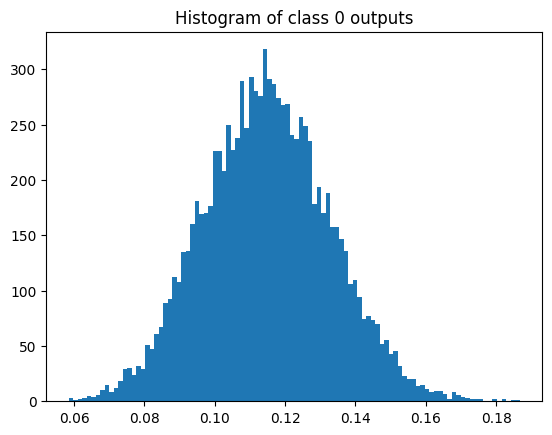

In [27]:
def load_activations_random(model, input_size, N=10000):

    activations, output = [], []
    X = torch.randn(N, input_size, dtype=torch.float32)
    for x in X:
        x /= torch.norm(x)
        L = model.forward_return_hidden(x)
        H, out = L[:-1], L[-1]
        activations.append([h.flatten().detach().numpy() for h in H])
        output.append(out.flatten().detach().numpy())

    return np.array(activations), np.array(output)

activations, output = load_activations_random(model, input_size)

target_class = 8
class_outputs = output[:, target_class]
print(class_outputs)

plt.hist(class_outputs, bins=100)
plt.title('Histogram of class 0 outputs')
plt.show()


In [28]:
final_hidden_layer = activations[:, -1, :]
final_hidden_layer_z = StandardScaler().fit_transform(final_hidden_layer)

lasso = Lasso(alpha=0.001)
lasso.fit(final_hidden_layer_z, class_outputs)
print(f'Lasso coefficients:')
print(lasso.coef_)

Lasso coefficients:
[-2.60973489e-03 -4.55633533e-04 -8.08451441e-04 -0.00000000e+00
 -1.11204572e-03  0.00000000e+00  6.84077269e-04 -1.30634508e-04
 -0.00000000e+00  1.26151092e-04 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  1.65714067e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.58273370e-03  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.52458961e-04  0.00000000e+00 -1.24527991e-03
  0.00000000e+00  3.93002469e-04 -0.00000000e+00 -0.00000000e+00
  1.20739744e-03  0.00000000e+00 -3.83990089e-04  9.40294285e-06
 -8.08720186e-04 -1.32535596e-03  2.13484003e-04 -0.00000000e+00
 -4.09653992e-04  0.00000000e+00  1.17787269e-04 -0.00000000e+00
 -0.00000000e+00  1.12886587e-03 -1.52701570e-04  1.17447285e-03
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.08113559e-03
 -7.51771440e-04  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.0

In [29]:
def prune_model(model, prune_nodes_idx):

    # copy the model

    pruned_model = FullyConnectedOneLayer(input_size, hidden_size, num_classes)
    pruned_model.load_state_dict(model.state_dict())

    mask = torch.ones(model.fc1.weight.shape[0])
    mask[prune_nodes_idx] = 0
    
    new_h1_weights = model.fc1.weight[mask.bool(), :]
    new_h1_bias = model.fc1.bias[mask.bool()]

    new_h1 = nn.Linear(model.fc1.weight.shape[1], model.fc1.weight.shape[0] - len(prune_nodes_idx))
    with torch.no_grad():
        new_h1.weight.copy_(new_h1_weights)
        new_h1.bias.copy_(new_h1_bias)

    pruned_model.fc1 = new_h1

    new_h2_weights = model.fc2.weight[:, mask.bool()]
    new_h2_bias = model.fc2.bias
    new_h2 = nn.Linear(model.fc2.weight.shape[1] - len(prune_nodes_idx), model.fc2.weight.shape[0])
    with torch.no_grad():
        new_h2.weight.copy_(new_h2_weights)
        new_h2.bias.copy_(new_h2_bias)

    pruned_model.fc2 = new_h2
    return pruned_model

prune_nodes_idx = np.where(abs(lasso.coef_) == 0)[0]
print(f'Pruning {len(prune_nodes_idx)} nodes')
pruned_model = prune_model(model, prune_nodes_idx)

Pruning 78 nodes


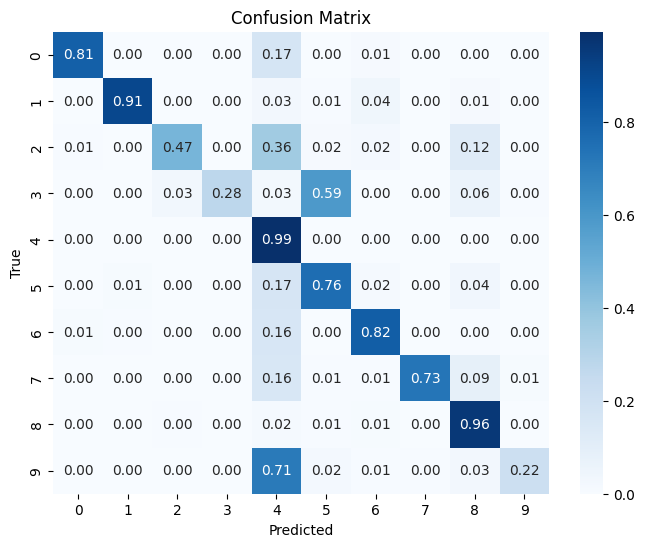

In [30]:
confusion_matrix = create_confusion_matrix(test_loader, pruned_model)
plot_confusion_matrix(confusion_matrix)

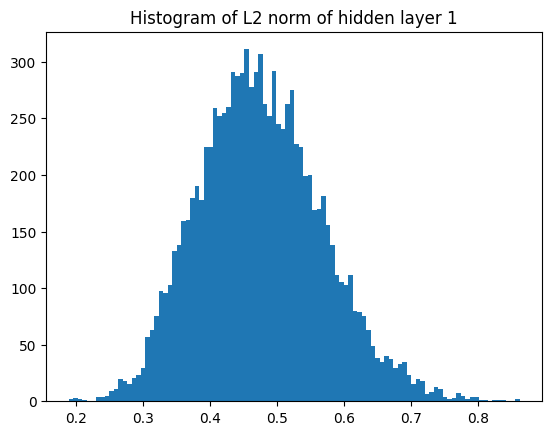

In [31]:
X = torch.randn(10000, input_size, dtype=torch.float32)

activations, output = [], []
for x in X:
    x /= torch.norm(x)
    L = pruned_model.forward_return_hidden(x)
    H, out = L[:-1], L[-1]
    activations.append([h.flatten().detach().numpy() for h in H])
    output.append(out.flatten().detach().numpy())

activations = np.array(activations)
output = np.array(output)

h1 = activations[:, 0, :]

h1_l2_norm = np.linalg.norm(h1, axis=1)
plt.hist(h1_l2_norm, bins=100)
plt.title('Histogram of L2 norm of hidden layer 1')
plt.show()



In [32]:
X_L1 = X.detach().numpy()

X_L1 = StandardScaler().fit_transform(X_L1)

lasso = Lasso(alpha=0.001)
lasso.fit(X_L1, h1_l2_norm)

print(f'Lasso coefficients:')
print(lasso.coef_)

prune_nodes_idx = np.where(abs(lasso.coef_) == 0)[0]
print(f'Pruning {len(prune_nodes_idx)} nodes')

Lasso coefficients:
[ 3.52935785e-06 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.89335726e-04
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.15639798e-03 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.09009929e-04 -4.94354812e-04
 -0.00000000e+00 -1.12333870e-03 -5.03856922e-04 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  6.45637920e-04 -2.84571172e-04
 -1.45091396e-03 -0.00000000e+00 -1.21907233e-05  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -2.34659572e-04 -0.00000000e+00
 -5.2

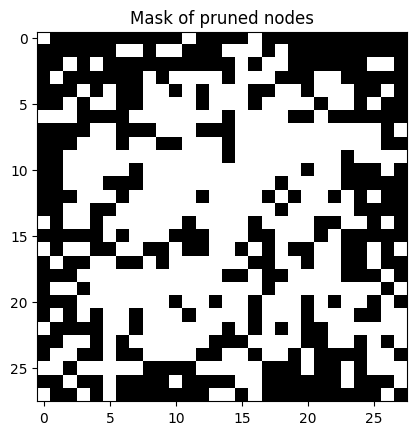

torch.Size([50, 426])


In [33]:
# print(pruned_model.fc1.weight.shape)

mask = torch.ones(pruned_model.fc1.weight.shape[1])
mask[prune_nodes_idx] = 0

# show visualisation of the mask
mask_img = mask.view(28, 28).detach().numpy()
plt.imshow(mask_img, cmap='gray')
plt.title('Mask of pruned nodes')
plt.show()


new_fc1_weights = pruned_model.fc1.weight[:, mask.bool()]

print(new_fc1_weights.shape)

new_h1 = nn.Linear(pruned_model.fc1.weight.shape[1] - len(prune_nodes_idx), pruned_model.fc1.weight.shape[0])

with torch.no_grad():
    new_h1.weight.copy_(new_fc1_weights)
    new_h1.bias.copy_(pruned_model.fc1.bias)

pruned_model.fc1 = new_h1


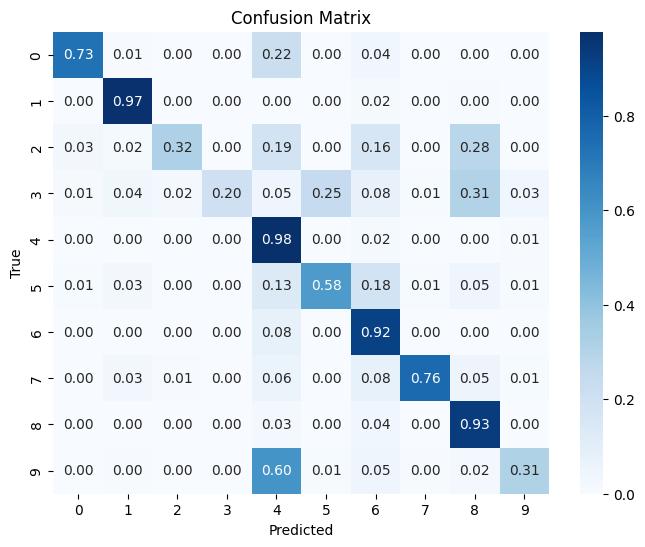

In [22]:
test_dataset = []
for i in range(len(test_loader.dataset)):
    x, label = test_loader.dataset[i]
    x = x.flatten()
    x = x[mask.bool()]
    test_dataset.append((x, label))

confusion_matrix = np.zeros((10, 10))

for x, label in test_dataset:
    out = pruned_model(x).detach().numpy()
    pred = np.argmax(out)
    confusion_matrix[label, pred] += 1

for i in range(10):
    confusion_matrix[i] /= np.sum(confusion_matrix[i])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()